## GNSS Lauf-Explorer
Dieses Notebook lädt die GNSS-Daten, bereitet die relevanten Spalten auf und zeigt für ein frei wählbares Zeitfenster die Spur und das Höhenprofil an.


In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from physics_computer.ski_alpine import SkiAlpine


In [53]:
data_path = Path('20251010_Daten_IMU/20251010_Schilthorn_HIM_3A_CS_RI_GNSS Kopie.csv')

df = pd.read_csv(data_path)
print(f'Datensatz geladen: {len(df):,} Zeilen')
df.head()


Datensatz geladen: 168,347 Zeilen


,time [POSIXms],timestamp [us],latitude [deg],longitude [deg],speedN [m/s],speedE [m/s],speedD [m/s],altitude [m]
0,1760082114000,1309250,46.56398,7.852534,0.0,0.0,0.0,2520.333
1,1760082114266,1437750,46.56398,7.852534,0.0,0.0,0.0,2520.333
2,1760082114400,1513750,46.56398,7.852534,0.0,0.0,0.0,2520.333
3,1760082114500,1614000,46.56398,7.852534,0.0,0.0,0.0,2520.333
4,1760082114600,1713750,46.56398,7.852534,0.0,0.0,0.0,2520.333


In [54]:
# Sortiere nach Zeit, erzeuge lokalisierte Zeitstempel und glätte die Höhe

df = df.sort_values('time [POSIXms]').reset_index(drop=True)
df['timestamp'] = pd.to_datetime(df['time [POSIXms]'], unit='ms', utc=True).dt.tz_convert('Europe/Zurich')
window_size = 25
df['altitude_smooth'] = df['altitude [m]'].rolling(window=window_size, min_periods=1, center=True).mean()
df[['timestamp', 'latitude [deg]', 'longitude [deg]', 'altitude [m]', 'altitude_smooth']].head()


,timestamp,latitude [deg],longitude [deg],altitude [m],altitude_smooth
0,1970-01-01 01:00:00+01:00,46.562063,7.846576,2591.717,2535.013077
1,1970-01-01 01:00:00+01:00,46.562080,7.849782,2588.672,2533.964500
2,2025-01-01 05:49:15+01:00,46.564154,7.852386,2511.978,2533.055733
3,2025-01-09 16:06:23.900000+01:00,46.564102,7.852491,2512.628,2532.260563
4,2025-01-10 08:13:15.600000+01:00,46.562071,7.849783,2591.293,2531.558941


### Zeitfenster-Explorer
Trage unten Start/Ende ein (lokale Zeit `Europe/Zurich`). Leer lassen, um offen zu lassen.


In [63]:
time_window_start = '2025-10-10 10:15:02'
time_window_end = '2025-10-10 10:25:25'
local_timezone = 'Europe/Zurich'


def parse_local_time(text):
    if text is None:
        return None
    text = str(text).strip()
    if not text:
        return None
    ts = pd.to_datetime(text)
    if ts.tzinfo is None:
        ts = ts.tz_localize(local_timezone)
    else:
        ts = ts.tz_convert(local_timezone)
    return ts

start_ts = parse_local_time(time_window_start)
end_ts = parse_local_time(time_window_end)
if start_ts is not None and end_ts is not None and end_ts <= start_ts:
    raise ValueError('Zeitfenster ungültig: Endzeit muss nach der Startzeit liegen')

mask = pd.Series(True, index=df.index)
if start_ts is not None:
    mask &= df['timestamp'] >= start_ts
if end_ts is not None:
    mask &= df['timestamp'] <= end_ts

window_df = df.loc[mask].copy()
print(f"Ausgewählte Punkte: {len(window_df):,}")
if not window_df.empty:
    print('Von', window_df['timestamp'].min(), 'bis', window_df['timestamp'].max())
window_df.head()


Ausgewählte Punkte: 6,231
Von 2025-10-10 10:15:02+02:00 bis 2025-10-10 10:25:25+02:00


,time [POSIXms],timestamp [us],latitude [deg],longitude [deg],speedN [m/s],speedE [m/s],speedD [m/s],altitude [m],timestamp,altitude_smooth,run_id,dt_s,horizontal_speed_mps,distance_step_m
19730,1760084102000,1989435500,46.563449,7.851372,6.469,4.602,1.370,2548.729,2025-10-10 10:15:02+02:00,2546.64708,2.0,0.1,7.938915,0.793891
19731,1760084102100,1989533750,46.563455,7.851377,6.757,4.500,2.184,2548.533,2025-10-10 10:15:02.100000+02:00,2546.46444,2.0,0.1,8.118316,0.811832
19732,1760084102200,1989633500,46.563462,7.851383,6.911,4.458,3.103,2548.259,2025-10-10 10:15:02.200000+02:00,2546.24868,2.0,0.1,8.224092,0.822409
19733,1760084102300,1989731750,46.563468,7.851389,6.725,4.439,4.162,2547.934,2025-10-10 10:15:02.300000+02:00,2545.99316,2.0,0.1,8.057937,0.805794
19734,1760084102400,1989833000,46.563474,7.851395,6.981,4.460,4.937,2547.492,2025-10-10 10:15:02.400000+02:00,2545.69440,2.0,0.1,8.284079,0.828408


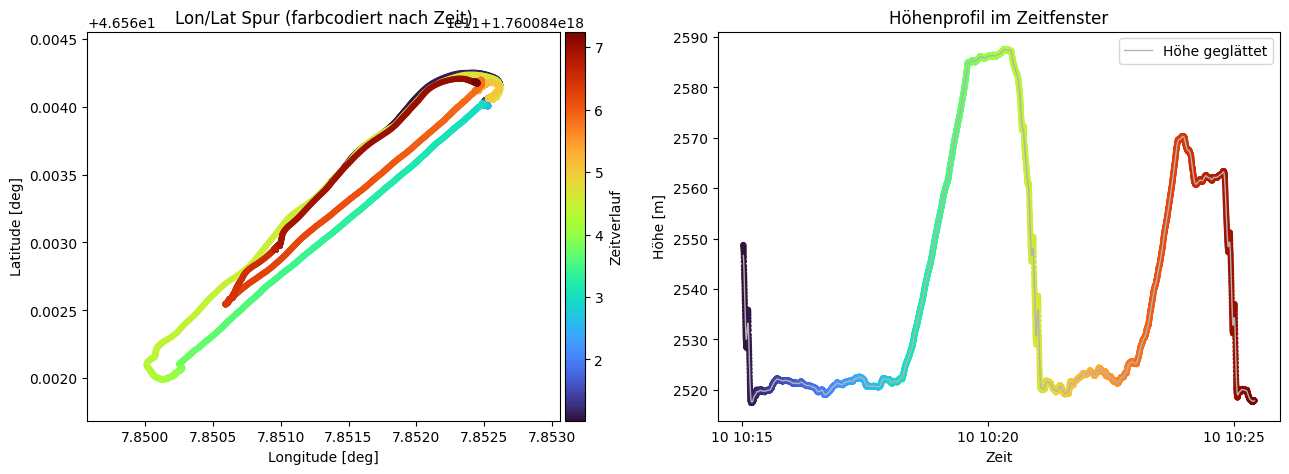

In [64]:
if window_df.empty:
    print('Keine Daten im gewählten Zeitfenster; bitte Start/Ende anpassen.')
else:
    ts_numeric = window_df['timestamp'].astype('int64')
    cmap = plt.cm.turbo
    norm = plt.Normalize(ts_numeric.min(), ts_numeric.max())

    fig, axes = plt.subplots(1, 2, figsize=(13, 5))

    sc = axes[0].scatter(window_df['longitude [deg]'], window_df['latitude [deg]'], c=ts_numeric, cmap=cmap, norm=norm, s=12)
    axes[0].set_xlabel('Longitude [deg]')
    axes[0].set_ylabel('Latitude [deg]')
    axes[0].set_title('Lon/Lat Spur (farbcodiert nach Zeit)')
    axes[0].axis('equal')
    cb = fig.colorbar(sc, ax=axes[0], pad=0.01)
    cb.set_label('Zeitverlauf')

    axes[1].scatter(window_df['timestamp'], window_df['altitude [m]'], c=ts_numeric, cmap=cmap, norm=norm, s=12)
    axes[1].plot(window_df['timestamp'], window_df['altitude_smooth'], color='0.7', linewidth=1, label='Höhe geglättet')
    axes[1].set_xlabel('Zeit')
    axes[1].set_ylabel('Höhe [m]')
    axes[1].set_title('Höhenprofil im Zeitfenster')
    axes[1].legend(loc='best')

    fig.tight_layout()
    plt.show()


### Runs über Höhen-Trigger identifizieren
Abfahrt startet beim Unterschreiten der Höhe `run_start_height` (von oben) und endet, sobald `run_end_height` erreicht wird.


In [57]:
run_start_height = 2580.0  # m
run_end_height = 2520.0    # m

if run_end_height >= run_start_height:
    raise ValueError('run_end_height muss kleiner als run_start_height sein')

alts = df['altitude_smooth'].to_numpy()
run_ids = np.full(len(df), np.nan)
current_run_id = 0
active = False

for i in range(1, len(df)):
    prev_alt = alts[i - 1]
    alt = alts[i]
    if not active:
        if np.isfinite(prev_alt) and np.isfinite(alt) and prev_alt > run_start_height and alt <= run_start_height:
            active = True
            current_run_id += 1
            run_ids[i] = current_run_id
    else:
        run_ids[i] = current_run_id
        if alt <= run_end_height:
            active = False

if active:
    run_ids[run_ids == current_run_id] = np.nan
    current_run_id -= 1

df['run_id'] = run_ids


In [58]:
if df['run_id'].notna().any():
    df['dt_s'] = df['timestamp'].diff().dt.total_seconds().clip(lower=0).fillna(0)
    df['horizontal_speed_mps'] = np.hypot(df['speedN [m/s]'], df['speedE [m/s]'])
    df['distance_step_m'] = df['horizontal_speed_mps'] * df['dt_s']

    run_summary = (
        df.dropna(subset=['run_id'])
          .groupby('run_id')
          .agg(
              start=('timestamp', 'min'),
              end=('timestamp', 'max'),
              duration_s=('dt_s', 'sum'),
              distance_m=('distance_step_m', 'sum'),
              vertical_drop_m=('altitude [m]', lambda s: s.iloc[0] - s.iloc[-1]),
              mean_speed_kph=('horizontal_speed_mps', lambda s: s.mean() * 3.6)
          )
    )
    run_summary['duration_min'] = run_summary['duration_s'] / 60
    run_summary = run_summary[['start', 'end', 'duration_s', 'duration_min', 'distance_m', 'vertical_drop_m', 'mean_speed_kph']]

    print(f"{len(run_summary)} Runs identifiziert (Start {run_start_height} m → Ende {run_end_height} m)")

    summary_display = run_summary.copy()
    summary_display['start'] = summary_display['start'].dt.strftime('%Y-%m-%d %H:%M:%S')
    summary_display['end'] = summary_display['end'].dt.strftime('%Y-%m-%d %H:%M:%S')
    summary_display = summary_display.round({
        'duration_s': 1,
        'duration_min': 2,
        'distance_m': 1,
        'vertical_drop_m': 1,
        'mean_speed_kph': 1
    })
    summary_display.head(20)
else:
    print('Keine Runs identifiziert – prüfe run_start_height/run_end_height oder die Daten.')


5 Runs identifiziert (Start 2580.0 m → Ende 2520.0 m)


### Physics Computer auf Zeitfenster
Der folgende Block nimmt genau das oben gewählte Zeitfenster, formatiert die Spalten wie im `01_test_pc`/`02_Ski_tests` Ordner und lässt anschließend den `SkiAlpine` Physics Computer laufen.


In [59]:
if window_df.empty:
    raise ValueError('Kein Zeitfenster ausgewählt – definiere Start/Ende, um den Physics Computer zu verwenden.')

column_map = {
    'latitude [deg]': 'latitude',
    'longitude [deg]': 'longitude',
    'altitude [m]': 'elevation',
    'speedN [m/s]': 'speedN',
    'speedE [m/s]': 'speedE',
    'speedD [m/s]': 'speedD',
}

pc_input = (
    window_df[['timestamp'] + list(column_map.keys())]
    .rename(columns=column_map)
    .copy()
    .reset_index(drop=True)
)

# Timestamp-Format wie im Original: %Y%m%dT%H%M%S%f (UTC)
timestamps = pc_input['timestamp']
if timestamps.dt.tz is None:
    timestamps = timestamps.dt.tz_localize('UTC')
else:
    timestamps = timestamps.dt.tz_convert('UTC')
pc_input['timestamp'] = timestamps.dt.strftime('%Y%m%dT%H%M%S%f')

pc_input['discipline_from_name'] = 'none'
pc_input['run'] = 1
pc_input['tf_id'] = 0

pc_input = pc_input[['timestamp', 'latitude', 'longitude', 'elevation', 'speedN', 'speedE', 'speedD', 'run', 'tf_id', 'discipline_from_name']]
print(f'Physics-Input Zeilen: {len(pc_input)}')
pc_input.head()


Physics-Input Zeilen: 231


,timestamp,latitude,longitude,elevation,speedN,speedE,speedD,run,tf_id,discipline_from_name
0,20251010T081502000000,46.563449,7.851372,2548.729,6.469,4.602,1.370,1,0,none
1,20251010T081502100000,46.563455,7.851377,2548.533,6.757,4.500,2.184,1,0,none
2,20251010T081502200000,46.563462,7.851383,2548.259,6.911,4.458,3.103,1,0,none
3,20251010T081502300000,46.563468,7.851389,2547.934,6.725,4.439,4.162,1,0,none
4,20251010T081502400000,46.563474,7.851395,2547.492,6.981,4.460,4.937,1,0,none


In [60]:
WINDOW_SIZE_PC = 31
pc_config = {
    'savitzky_golay': {
        'window_size': WINDOW_SIZE_PC,
        'order': 3,
    }
}

alpine = SkiAlpine(df=pc_input.copy(), config=pc_config)
pc_df = alpine.compute()
print(f'Physics Computer Ergebnis: {pc_df.shape[0]} Zeilen, {pc_df.shape[1]} Spalten')
pc_df[['timestamp', 'x', 'y', 'z', 'v_sp', 'a_sp', 'k', 'ifly']].head()


2025-12-11 11:38:22.063 | INFO     | physics_computer.base:_modify_config:57 - running _modify_config ...
2025-12-11 11:38:22.064 | INFO     | physics_computer.base:_convert_timestamp:148 - running _convert_timestamp ...
2025-12-11 11:38:22.069 | INFO     | physics_computer.base:_convert_coordinates:100 - running _convert_coordinates ...
2025-12-11 11:38:22.085 | INFO     | physics_computer.base:_compute_absolute_value:210 - running _compute_absolute_value ...
2025-12-11 11:38:22.100 | INFO     | physics_computer.base:_compute_tangential_vector:235 - running _compute_tangential_vector ...
2025-12-11 11:38:22.185 | INFO     | physics_computer.base:_compute_k:253 - running _compute_k ...
2025-12-11 11:38:22.197 | INFO     | physics_computer.base:_compute_k_xy:274 - running _compute_k_xy ...
2025-12-11 11:38:22.204 | INFO     | physics_computer.base:_compute_slope:293 - running _compute_slope ...
2025-12-11 11:38:22.212 | INFO     | physics_computer.base:_compute_accelerations:336 - runni

Physics Computer Ergebnis: 231 Zeilen, 50 Spalten


,timestamp,x,y,z,v_sp,a_sp,k,ifly
0,20251010T081502000000,0.000000,0.000000,2548.729,7.769162,6.114050,0.072535,0
1,20251010T081502100000,0.454229,0.660228,2548.533,8.201935,5.839255,0.057494,0
2,20251010T081502200000,0.908781,1.342680,2548.259,8.641777,5.570114,0.045526,0
3,20251010T081502300000,1.378338,2.002685,2547.934,9.082593,5.307487,0.036042,0
4,20251010T081502400000,1.832890,2.685137,2547.492,9.519745,5.052390,0.028529,0


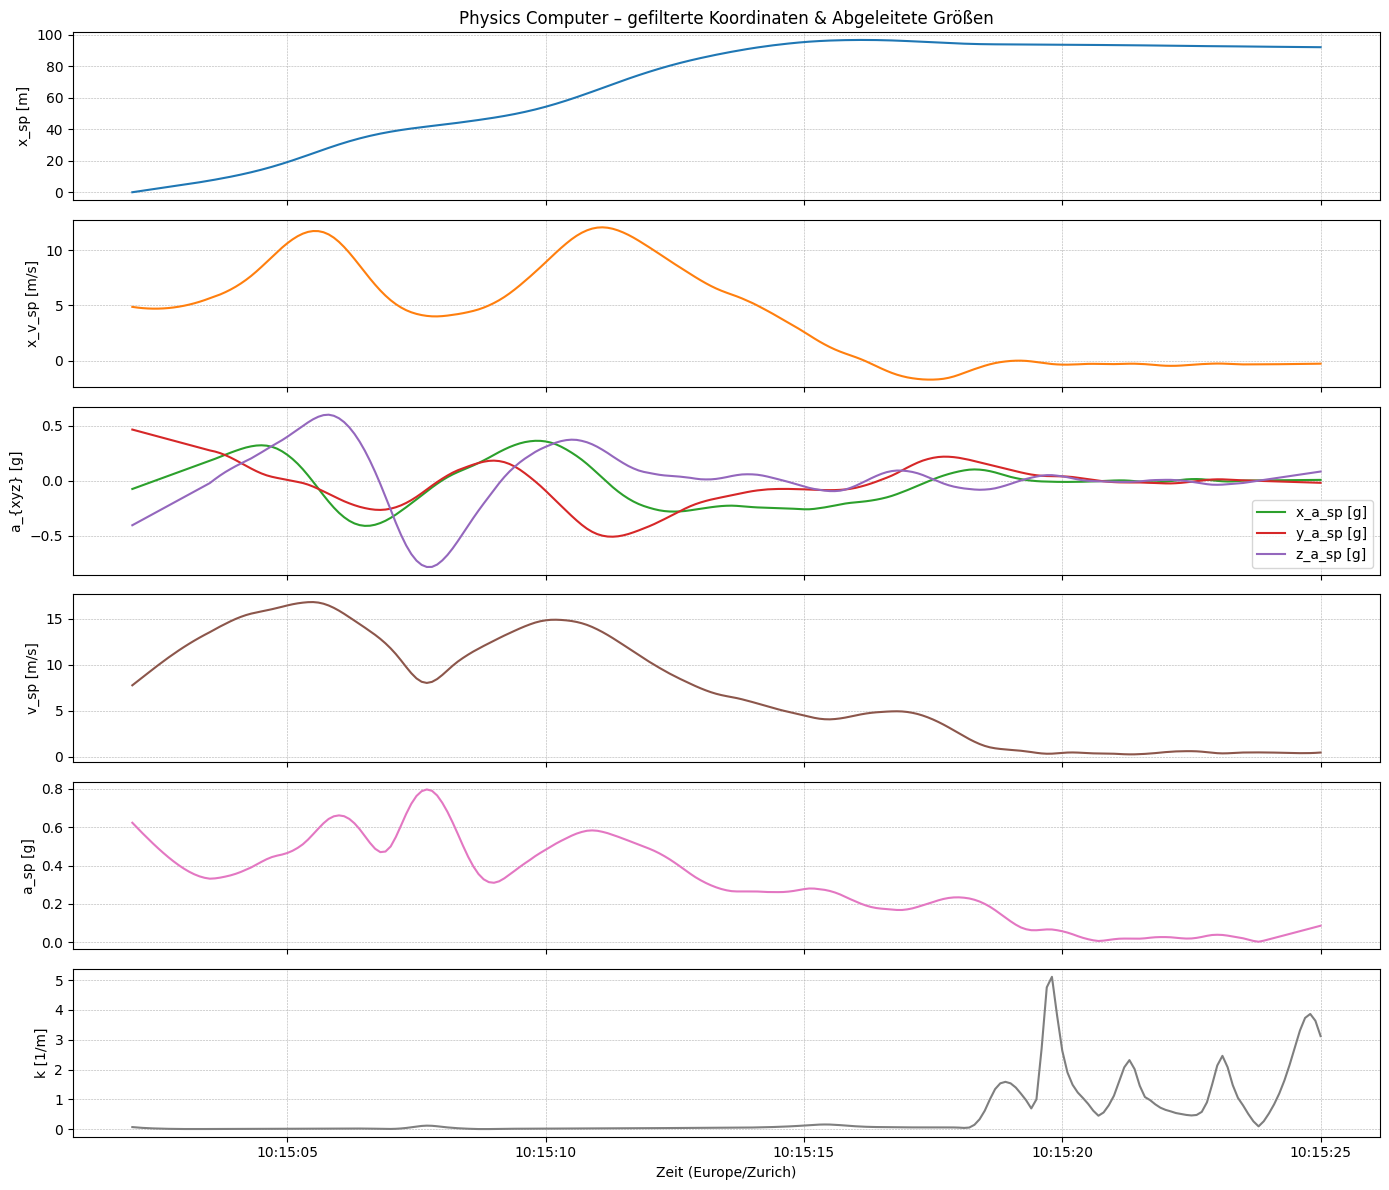

In [61]:
if 'pc_df' not in locals() or pc_df.empty:
    print('Kein Physics-Computer-Resultat verfügbar.')
else:
    time_axis = pd.to_datetime(pc_df['timestamp'], format='%Y%m%dT%H%M%S%f', utc=True)
    target_timezone = 'UTC'
    if 'local_timezone' in globals() or 'local_timezone' in locals():
        target_timezone = local_timezone
        time_axis = time_axis.dt.tz_convert(local_timezone)
    g_const = 9.80665

    fig, axes = plt.subplots(6, 1, figsize=(14, 12), sharex=True)

    axes[0].plot(time_axis, pc_df['x_sp'], color='C0')
    axes[0].set_ylabel('x_sp [m]')
    axes[0].set_title('Physics Computer – gefilterte Koordinaten & Abgeleitete Größen')

    axes[1].plot(time_axis, pc_df['x_v_sp'], color='C1')
    axes[1].set_ylabel('x_v_sp [m/s]')

    accel_cols = ['x_a_sp', 'y_a_sp', 'z_a_sp']
    accel_colors = ['C2', 'C3', 'C4']
    for col, color in zip(accel_cols, accel_colors):
        if col in pc_df.columns:
            axes[2].plot(time_axis, pc_df[col] / g_const, color=color, label=f"{col} [g]")
    axes[2].set_ylabel('a_{xyz} [g]')
    if axes[2].lines:
        axes[2].legend(loc='best')

    axes[3].plot(time_axis, pc_df['v_sp'], color='C5')
    axes[3].set_ylabel('v_sp [m/s]')

    axes[4].plot(time_axis, pc_df['a_sp'] / g_const, color='C6')
    axes[4].set_ylabel('a_sp [g]')

    axes[5].plot(time_axis, pc_df['k'], color='C7')
    axes[5].set_ylabel('k [1/m]')
    axes[5].set_xlabel(f'Zeit ({target_timezone})')

    for ax in axes:
        ax.grid(True, linestyle='--', linewidth=0.4)

    plt.tight_layout()
    plt.show()

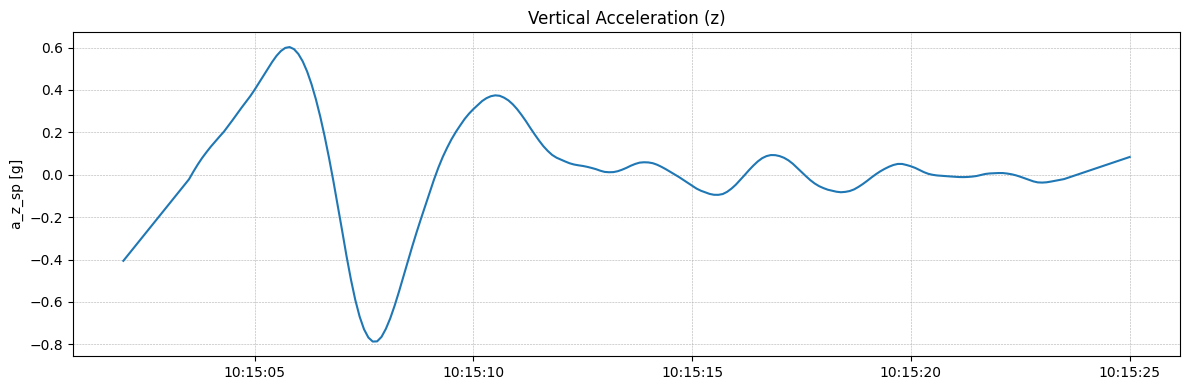

Zeitfenster (UTC µs):
  Start (POSIX): 1760084102000000 (2025-10-10 10:15:02+02:00)
  Ende  (POSIX): 1760084125000000 (2025-10-10 10:15:25+02:00)
timestamp [us] aus CSV:
  Start: 1989435500
  Ende : 2012429500


In [62]:
if 'time_axis' not in locals():
    raise ValueError('time_axis nicht gefunden – bitte zuerst den Physics-Plot ausführen.')

if 'g_const' not in locals():
    g_const = 9.80665

if 'pc_df' not in locals() or pc_df.empty:
    print('Kein Physics-Computer-Resultat verfügbar.')
else:
    plt.figure(figsize=(12, 4))
    plt.plot(time_axis, pc_df['z_a_sp'] / g_const)
    plt.ylabel('a_z_sp [g]')
    plt.title('Vertical Acceleration (z)')
    plt.grid(True, linestyle='--', linewidth=0.4)
    plt.tight_layout()
    plt.show()

    start_local = time_axis.iloc[0]
    end_local = time_axis.iloc[-1]
    start_utc = start_local.tz_convert('UTC')
    end_utc = end_local.tz_convert('UTC')
    start_us_posix = int(start_utc.value // 1_000)
    end_us_posix = int(end_utc.value // 1_000)

    print('Zeitfenster (UTC µs):')
    print(f"  Start (POSIX): {start_us_posix} ({start_local})")
    print(f"  Ende  (POSIX): {end_us_posix} ({end_local})")

    if 'timestamp [us]' in window_df.columns and 'time [POSIXms]' in window_df.columns:
        start_ms = int(start_utc.value // 1_000_000)
        end_ms = int(end_utc.value // 1_000_000)

        def lookup_timestamp_us(target_ms):
            matches = window_df.loc[window_df['time [POSIXms]'] == target_ms, 'timestamp [us]']
            if not matches.empty:
                return int(matches.iloc[0]), False
            idx = (window_df['time [POSIXms]'] - target_ms).abs().idxmin()
            return int(window_df.loc[idx, 'timestamp [us]']), True

        start_us_csv, start_approx = lookup_timestamp_us(start_ms)
        end_us_csv, end_approx = lookup_timestamp_us(end_ms)

        start_note = ' (approx.)' if start_approx else ''
        end_note = ' (approx.)' if end_approx else ''
        print('timestamp [us] aus CSV:')
        print(f"  Start: {start_us_csv}{start_note}")
        print(f"  Ende : {end_us_csv}{end_note}")
    else:
        print('Spalte "timestamp [us]" oder "time [POSIXms]" nicht verfügbar – keine CSV-Werte ausgegeben.')